In [1]:
"""
@author: Enrico Regolin
"""
# observability / controllability example
import numpy as np

In [2]:
#A = np.array([[0,1,0] , [1,1,0], [0,0,1]])
A = np.array([[0,1,0] , [0,0,1], [1,-1,2]])
C = np.array([[1,0,0]])
B = np.array( [ [0],[0],[1]])

# build obs and ctb matrices
m = C
n = B
Om = C
Cm = B
for i in range(A.shape[0]-1):
    m = np.matmul(m,A)
    n = np.matmul(A,n)
    Om = np.append(Om,m, axis = 0)
    Cm = np.append(Cm,n, axis = 1)
    
# calculate rank    
print(Om)
print(f'observability matrix rank = {np.linalg.matrix_rank(Om)}')
print(Cm)
print(f'controllability matrix rank = {np.linalg.matrix_rank(Cm)}')

[[1 0 0]
 [0 1 0]
 [0 0 1]]
observability matrix rank = 3
[[0 0 1]
 [0 1 2]
 [1 2 3]]
controllability matrix rank = 3


In [3]:
# pole placement / Luenberger observer
from scipy.signal import place_poles
import matplotlib.pyplot as plt

In [4]:
?place_poles

Signature: place_poles(A, B, poles, method='YT', rtol=0.001, maxiter=30)
Docstring:
Compute K such that eigenvalues (A - dot(B, K))=poles.

K is the gain matrix such as the plant described by the linear system
``AX+BU`` will have its closed-loop poles, i.e the eigenvalues ``A - B*K``,
as close as possible to those asked for in poles.

SISO, MISO and MIMO systems are supported.

Parameters
----------
A, B : ndarray
    State-space representation of linear system ``AX + BU``.
poles : array_like
    Desired real poles and/or complex conjugates poles.
    Complex poles are only supported with ``method="YT"`` (default).
method: {'YT', 'KNV0'}, optional
    Which method to choose to find the gain matrix K. One of:

        - 'YT': Yang Tits
        - 'KNV0': Kautsky, Nichols, Van Dooren update method 0

    See References and Notes for details on the algorithms.
rtol: float, optional
    After each iteration the determinant of the eigenvectors of
    ``A - B*K`` is compared to its previous v

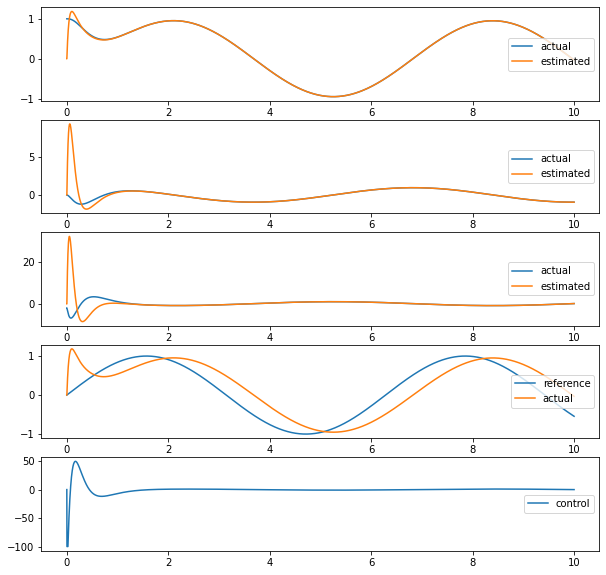

In [5]:
# desired eigenvalues of closed loop controlled system and observer
ctrl_poles  = 1*np.array([-10,-5,-4])
obsrv_poles = 1*np.array([-5,-20,-10])

# gains for pole placement
K_placement = place_poles(A, B, ctrl_poles)
L_placement = place_poles(A.T, C.T, obsrv_poles)
K = K_placement.gain_matrix
L = L_placement.gain_matrix.T

# initialize arrays and logs
x = np.array([1,0,-2],dtype = np.float64).T
x_hat = np.zeros(x.shape)
err_x = np.zeros(x.shape)
u = 0
y = 0
y_hat = 0

x_hist = x[np.newaxis,:]
x_hat_hist = x_hat[np.newaxis]
u_hist = np.array([0])
x_ref_hist = np.array([0])


t = 0
dt = 0.001

for _ in range(int(10/dt)):
    
    t+= dt
    x_ref = np.sin(t)
    
    # control action
    #err_x = x_ref*np.array([1,0,0]) - x_hat
    err_x = x_ref*np.array([1,0,0]) - x
    u = np.matmul(K,err_x)
    u = np.clip(u,-100,100)

    # observer
    err = y - y_hat
    x_hat_dot = np.matmul(A,x_hat) + np.matmul(B,u) + L[:,0]*err
    x_hat += x_hat_dot*dt
    y_hat = np.matmul(C,x_hat)
    
    # plant
    x_dot = np.matmul(A,x) + np.matmul(B,u)
    x += x_dot*dt
    y = np.matmul(C,x)

    # log history    
    x_hist = np.append(x_hist, x[np.newaxis,:], axis = 0)
    x_hat_hist = np.append(x_hat_hist, x_hat[np.newaxis,:], axis = 0)
    u_hist = np.append(u_hist, u)
    x_ref_hist = np.append(x_ref_hist, x_ref)
    

plt.rcParams["figure.figsize"] = (10,10)    
t = dt*np.arange(u_hist.shape[0])
fig,ax = plt.subplots(5,1)
ax[0].plot(t,x_hist[:,0],t,x_hat_hist[:,0])
ax[0].legend(['actual','estimated'], loc = 5)
ax[1].plot(t,x_hist[:,1],t,x_hat_hist[:,1])
ax[1].legend(['actual','estimated'], loc = 5)
ax[2].plot(t,x_hist[:,2],t,x_hat_hist[:,2])
ax[2].legend(['actual','estimated'], loc = 5)

ax[3].plot(t,x_ref_hist,t,x_hat_hist[:,0])
ax[3].legend(['reference','actual'], loc = 5)
ax[4].plot(t,u_hist)
ax[4].legend(['control'], loc = 5)